# Homework 7

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Saturday, October 27th, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators

** Place the name of everyone who's submitting this assignment here**

<div class="answer-separator">
------------------------
</div>

In [61]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
import seaborn as sns
%matplotlib inline

## Standard boilerplate to import torch and torch related modules
import torch

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn

## Question 1: Mon pays c'est l'MNIST. Mon cœur est brise de Logistic Regression.

The [*MNIST* dataset](https://en.wikipedia.org/wiki/MNIST_database) is one of the classic datasets in Machine Learning and is often one of the first datasets against which new classification algorithms test themselves.  It consists of 70,000 images of handwritten digits, each of which is 28x28 pixels. You will be using PyTorch to build a handwritten digit classifier that you will train, validate, and test with MNIST. 

Your classifier MUST implement a multinomial logistic regression model (using softmax). It will take as input an array of pixel values in an image and output the images most likely digit label (i.e. 0-9). You should think of the pixel values as features of the input vector.  

Using the softmax formulation, your PyTorch model should computes the cost function using an L2 regularization approach (see `optim.SGD` in PyTorch or write your own cost function) and minimize the resulting cost function using mini-batch stochastic gradient descent.  We provided  extensive template code in lab.

Construct and train your classifier using a batch size of 256 examples, a learning rate $\eta$=0.1, and a regularization factor $\lambda$=0.01.

1.1. Plot 10 sample images from the MNIST dataset (to develop intuition for the feature space).

1.2. Currently the MNIST dataset in Torchvision allows a Train/Test split.  Use PyTorch dataloader functionality to create a Train/Validate/Test split  of 50K/10K/10K samples.

**Hint:** Lab described a way to do it keeping within the MNIST `DataLoader` workflow: the key is to pass a `SubsetRandomSampler` to `DataLoader`

1.3. Construct a softmax formulation in PyTorch of multinomial logistic regression with Cross Entropy Loss.

1.4. Train your model using SGD to minimize the cost function. Use as many epochs as you need to achive convergence.

1.5. Plot the cross-entropy loss on the training set as a function of iteration.

1.6. Using classification accuracy, evaluate how well your model is performing on the validation set at the end of each epoch. Plot this validation accuracy as the model trains.

1.6. Duplicate this plot for some other values of the regularization parameter $\lambda$. When should you stop the training for each of the different values of λ? Give an approximate answer supported by using the plots.

1.7. Select what you consider the best regularization parameter and predict the labels of the test set. Compare your predictions with the given labels. What classification accuracy do you obtain on the training and test sets?

1.8. What classes are most likely to be misclassified? Plot some misclassified training and test set images.

**Gratuitous Titular Reference**:  The recently departed French rockstar Johnny Hallyday just posthumously released what looks to be his biggest album ever "Mon pays c'est l'amour".  The album sold 300,000 copies on its first day of release.

> 1.1. Plot 10 sample images from the MNIST dataset (to develop intuition for the feature space).

We plot 10 samples from the training dataset.

In [2]:
# download and transform train dataset
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../mnist_data', 
                                                          download=True, 
                                                          train=True,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])), 
                                           batch_size=10, 
                                           shuffle=True)

In [3]:
images, labels = next(iter(train_loader))
print(labels)

tensor([2, 4, 5, 4, 1, 6, 4, 7, 2, 1])


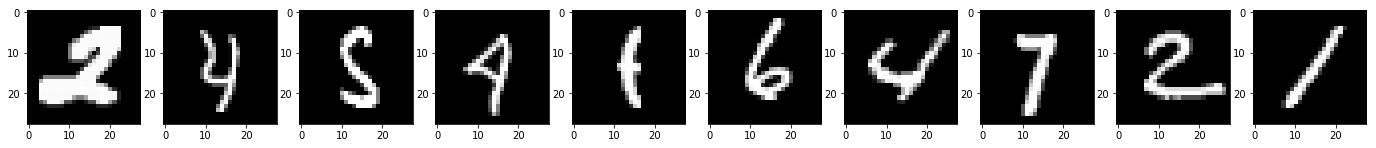

In [4]:
plt.figure(figsize=(24, 24))
plt.tight_layout()

for i in range(len(images)):
    plt.subplot(1, len(images), i+1)
    plt.imshow(images[i, 0, :, :], cmap='gray')

> 1.2. Currently the MNIST dataset in Torchvision allows a Train/Test split.  Use PyTorch dataloader functionality to create a Train/Validate/Test split  of 50K/10K/10K samples.

> **Hint:** Lab described a way to do it keeping within the MNIST `DataLoader` workflow: the key is to pass a `SubsetRandomSampler` to `DataLoader`

We use `random_split` instead of `SubsetRandomSampler`.

In [5]:
mnist_train = datasets.MNIST('../mnist_data',
                             train=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(), # first, convert image to PyTorch tensor
                                 transforms.Normalize((0.5,), (0.5,)) # normalize inputs
                                 ]))

train, valid = torch.utils.data.random_split(mnist_train, lengths=[50000, 10000])
train_loader = torch.utils.data.DataLoader(train, batch_size=32)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=32)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../mnist_data',
                   train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(), # first, convert image to PyTorch tensor
                       transforms.Normalize((0.5,), (0.5,)) # normalize inputs
                       ])))

> 1.3. Construct a softmax formulation in PyTorch of multinomial logistic regression with Cross Entropy Loss.

In [35]:
class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Output layer, 10 units - one for each digit
        self.fc = torch.nn.Linear(28*28, 10)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        x = self.fc(x)
        return x

model = Network()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.1)

> 1.4. Train your model using SGD to minimize the cost function. Use as many epochs as you need to achive convergence.

In [36]:
def calc_stats(model, generator, criterion):
    """
    Calculate loss and accuracy
    
    :param model: pytorch model
    :param genertor: data generator
    :param criterion: loss function
    """
    running_loss = 0
    running_acc = 0
    n_samples = 0
    
    # For efficiency, don't calculate any gradients
    with torch.no_grad():
        for images, labels in iter(generator):
            images.resize_(images.size()[0], 28*28)
            output = model.forward(images)
            loss = criterion(output, labels)
            
            # Bookkeeping
            batch_predictions = output.argmax(dim=1)
            batch_acc = (batch_predictions == labels).double().sum()
            
            running_loss += loss.item() * len(images)
            running_acc += batch_acc
            
            n_samples += len(images)
            
        return running_loss / n_samples, running_acc / n_samples

In [37]:
epochs = 3

def train_model(model, epochs, train_loader, valid_loader, optimizer, criterion):

    train_loss = np.empty(epochs)
    val_loss = np.empty(epochs)
    train_acc = np.empty(epochs)
    val_acc = np.empty(epochs)


    for e in range(epochs):
        running_loss = 0
        running_acc = 0
        for images, labels in iter(train_loader):
            # Flatten images to 28*28 vector
            images.resize_(images.size()[0], 28*28)

            # Remove gradient
            optimizer.zero_grad()

            # Forward and backward passes
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            # Bookkeeping
            predictions = output.argmax(dim=1)
            batch_acc = (predictions == labels).double().sum()

            running_loss += loss.item() * len(images)
            running_acc += batch_acc


        print("Epoch: {}/{}... ".format(e+1, epochs),
              "Loss: {:.4f}".format(running_loss/50000),
              "Accuracy: {:.4f}".format(running_acc/50000))
        train_loss[e] = running_loss / 50000
        train_acc[e] = running_acc / 50000
        running_loss = 0
        running_acc = 0

        val_loss[e], val_acc[e] = calc_stats(model, valid_loader, criterion)
    
    summary_stats = pd.DataFrame({'epoch': np.arange(epochs) + 1,
                                  'train_loss': train_loss,
                                  'val_loss': val_loss,
                                  'train_acc': train_acc,
                                  'val_acc': val_acc})
    
    return model, summary_stats

model, summary_stats = train_model(model, epochs, train_loader, valid_loader, optimizer, criterion)

Epoch: 1/3...  Loss: 0.6194 Accuracy: 0.8502


KeyboardInterrupt: 

> 1.5. Plot the cross-entropy loss on the training set as a function of iteration.

Text(0.5,1,'Training loss vs epochs')

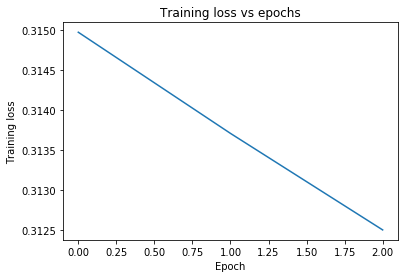

In [19]:
plt.plot(summary_stats['epoch'], summary_stats['train_loss'])
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.title("Training loss vs epochs")

> 1.6. Using classification accuracy, evaluate how well your model is performing on the validation set at the end of each epoch. Plot this validation accuracy as the model trains.

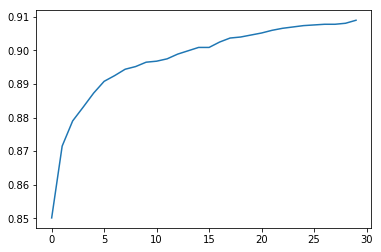

In [12]:
plt.plot(summary_stats['epoch'], summary_stats['val_acc'])

> 1.7. Duplicate this plot for some other values of the regularization parameter $\lambda$. When should you stop the training for each of the different values of λ? Give an approximate answer supported by using the plots.

In [78]:
lambdas = [10.0, 1.0, 0.1, 0.01, 0.001, 0.0001]
def eval_lambda(reg):
    """
    Evaluate single regularization parameter
    """
    model_new = Network()

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model_new.parameters(), lr=0.01, weight_decay=reg)
    
    _, summary_stats = train_model(model_new, epochs=10, train_loader=train_loader, valid_loader=valid_loader,
                                   optimizer=optimizer, criterion=criterion)
    
    summary_stats['lambda'] = reg
    
    return summary_stats


results = pd.concat([eval_lambda(reg) for reg in lambdas])
results

Epoch: 1/10...  Loss: 1.9903 Accuracy: 0.3920
Epoch: 2/10...  Loss: 1.9885 Accuracy: 0.3932
Epoch: 3/10...  Loss: 1.9885 Accuracy: 0.3932
Epoch: 4/10...  Loss: 1.9885 Accuracy: 0.3932
Epoch: 5/10...  Loss: 1.9885 Accuracy: 0.3932
Epoch: 6/10...  Loss: 1.9885 Accuracy: 0.3932
Epoch: 7/10...  Loss: 1.9885 Accuracy: 0.3932
Epoch: 8/10...  Loss: 1.9885 Accuracy: 0.3932
Epoch: 9/10...  Loss: 1.9885 Accuracy: 0.3932
Epoch: 10/10...  Loss: 1.9885 Accuracy: 0.3932
Epoch: 1/10...  Loss: 1.0955 Accuracy: 0.7799
Epoch: 2/10...  Loss: 1.0637 Accuracy: 0.7933
Epoch: 3/10...  Loss: 1.0637 Accuracy: 0.7933
Epoch: 4/10...  Loss: 1.0637 Accuracy: 0.7933
Epoch: 5/10...  Loss: 1.0637 Accuracy: 0.7933
Epoch: 6/10...  Loss: 1.0637 Accuracy: 0.7933
Epoch: 7/10...  Loss: 1.0637 Accuracy: 0.7933
Epoch: 8/10...  Loss: 1.0637 Accuracy: 0.7933
Epoch: 9/10...  Loss: 1.0637 Accuracy: 0.7933
Epoch: 10/10...  Loss: 1.0637 Accuracy: 0.7933
Epoch: 1/10...  Loss: 0.6196 Accuracy: 0.8496
Epoch: 2/10...  Loss: 0.5102 Acc

,epoch,train_acc,train_loss,val_acc,val_loss,lambda
0,1,0.39204,1.990334,0.2051,2.062392,10.0000
1,2,0.39318,1.988514,0.2051,2.062392,10.0000
2,3,0.39318,1.988514,0.2051,2.062392,10.0000
3,4,0.39318,1.988514,0.2051,2.062392,10.0000
4,5,0.39318,1.988514,0.2051,2.062392,10.0000
5,6,0.39318,1.988514,0.2051,2.062392,10.0000
6,7,0.39318,1.988514,0.2051,2.062392,10.0000
7,8,0.39318,1.988514,0.2051,2.062392,10.0000
8,9,0.39318,1.988514,0.2051,2.062392,10.0000
9,10,0.39318,1.988514,0.2051,2.062392,10.0000


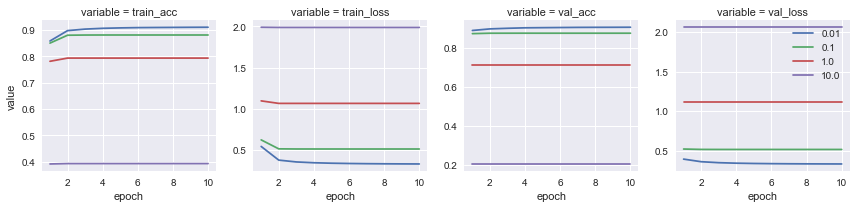

In [77]:
foo = pd.melt(results, id_vars=['epoch', 'lambda'])
g = sns.FacetGrid(foo, hue="lambda", col='variable', sharey=False)
g.map(plt.plot, "epoch", "value")
plt.legend()

> 1.8. Select what you consider the best regularization parameter and predict the labels of the test set. Compare your predictions with the given labels. What classification accuracy do you obtain on the training and test sets?

> 1.9. What classes are most likely to be misclassified? Plot some misclassified training and test set images.

<div class="answer-separator">
------------------------
</div>

## Question 2: MNIST MLP!  Find out what that means to me.  MNIST MLP!  Take care, TCB!

The multilayer perceptron can be understood as a logistic regression classifier in which the input is first transformed using a learnt non-linear transformation. The non-linear transformation is often chosen to be either the logistic function or the $\tanh$ function or the RELU function, and its purpose is to project the data into a space where it becomes linearly separable. The output of this so-called hidden layer is then passed to the logistic regression graph that we have constructed in the first problem. 

![](http://deeplearning.net/tutorial/_images/mlp.png)

We'll construct a model with **1 hidden layer**. That is, you will have an input layer, then a hidden layer with the nonlinearity, and finally an output layer with cross-entropy loss (or equivalently log-softmax activation with a negative log likelihood loss).

2.1. Using a similar architecture as in Question 1 and the same training, validation and test sets, build a PyTorch model for the multilayer perceptron. Use the $\tanh$ function as the non-linear activation function. 

2.2. The initialization of the weights matrix for the hidden layer must assure that the units (neurons) of the perceptron operate in a regime where information gets propagated. For the $\tanh$ function, you may find it advisable to initialize with the interval $\left[-\sqrt{\frac{6}{fan_{in}+fan_{out}}},\sqrt{\frac{6}{fan_{in}+fan_{out}}}\right]$, where $fan_{in}$ is the number of units in the $(i-1)$-th layer, and $fan_{out}$ is the number of units in the i-th layer.  This is known as **Xavier Initialization**.  Use Xavier Initialization to initialize your MLP.  Feel free to use PyTorch's in-built Xavier Initialization methods.

2.3. Using $\lambda = 0.01$ to compare with Question 1, experiment with the learning rate (try 0.1 and 0.01 for example), batch size (use 64, 128 and 256) and the number of units in your hidden layer (use between 25 and 200 units). For what combination of these parameters do you obtain the highest validation accuracy?  You may want to start with 20 epochs for running time and experiment a bit to make sure that your models reach convergence. 

2.4. For your best combination plot the cross-entropy loss on the training set as a function of iteration.

2.5. For your best combination use classification accuracy to evaluate how well your model is performing on the validation set at the end of each epoch. Plot this validation accuracy as the model trains.

2.6. Select what you consider the best set of parameters and predict the labels of the test set. Compare your predictions with the given labels. What classification accuracy do you obtain on the training and test sets?

2.7. How does your test accuracy compare to that of the logistic regression classifier in Question 1?  Compare best parameters for both models.

2.8. What classes are most likely to be misclassified? Plot some misclassified training and test set images.


**Gratuitous Titular Reference**:  Respect, originally performed by Otis Redding, became a huge hit and an anthem for the recently departed "Queen of Soul" Aretha Franklin.  Respect is often credited with popularizing the word usages "propers" (a synonym for respect) and "sock it to me".

<div class="answer-separator">
------------------------
</div>